In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os, cv2

from utils import get_image_filepaths, get_data, dice_coef
from Unet import UNet, build_unet

import warnings
warnings.filterwarnings('ignore')

In [7]:
msk_path = r'/home/suetin/Projects/VSCode/ComputerVision/HeartSegmentation/train/masks/images/2010.jpeg'
image = cv2.imread(msk_path, 0)
image = image / image.max()

plt.imshow(image)

[ WARN:0@67.734] global loadsave.cpp:244 findDecoder imread_('/home/suetin/Projects/VSCode/ComputerVision/HeartSegmentation/train/masks/images/2010.jpeg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'max'

In [9]:

mask = np.where((image > 0.1) & (image < 0.9), 1., 0.)

plt.imshow(mask)

TypeError: '>' not supported between instances of 'NoneType' and 'float'

# The problems with target. Delete line in bottom

## Solutions:
- In hand (with trasholds)
- KMeans (Clusterisation)

In [10]:
def area2cont(im_area):
    im_cont = im_area.copy()
    y, x = np.where(im_cont != 0)
    for i, j in zip(x, y):
        if im_area[j+1, i] != 0 and im_area[j-1, i] != 0 and im_area[j, i-1] != 0 and im_area[j, i+1] != 0:
            im_cont[j, i] = 0
    return im_cont

In [ ]:
im_cont = mask.copy()
im_cont = area2cont(im_cont)
cont_y, cont_x = np.where(im_cont != 0)
cent_x, cent_y = np.mean(cont_x), np.mean(cont_y)

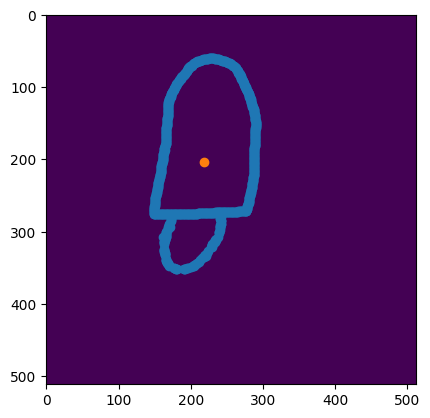

In [ ]:
plt.imshow(im_cont)
plt.scatter(cont_x, cont_y)
plt.scatter(cent_x, cent_y)

In [ ]:
len(cont_x), len(cont_x) // 50

(702, 14)

In [15]:
from skimage.morphology import square, erosion
from skimage import feature # filter, 
from skimage import measure

In [12]:
new_mask = erosion(mask, square(3))

plt.imshow(new_mask)

NameError: name 'mask' is not defined

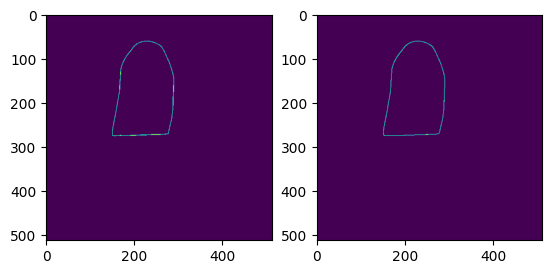

In [ ]:
edges1 = feature.canny(new_mask)
edges2 = feature.canny(new_mask, sigma=3)

plt.subplot(121)
plt.imshow(edges1)

plt.subplot(122)
plt.imshow(edges2)

In [ ]:

# Find contours at a constant value of 0.8
contours = measure.find_contours(new_mask, 0.8)[0]   # First index because it's list

plt.imshow(new_mask)
plt.plot(contours[:, 1], contours[:, 0])

NameError: name 'new_mask' is not defined

In [ ]:
contours.shape, len(cont_y), np.sum(edges2)

((715, 2), 702, 663)

In [16]:
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon

Number of coordinates: 1429 95


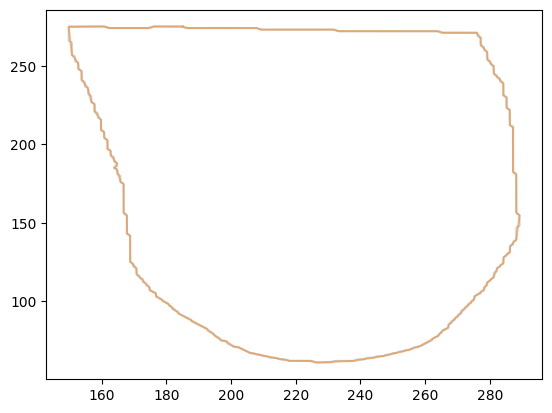

In [ ]:
# 
for _ in range(5):
    mask_poly = subdivide_polygon(contours, degree=3, preserve_ends=True)

# approximate subdivided polygon with Douglas-Peucker algorithm
appr_msk = approximate_polygon(mask_poly, tolerance=0.5)

print("Number of coordinates:", len(mask_poly), len(appr_msk))

# plt.plot(contours[:, 1], contours[:, 0], alpha=0.3)
plt.plot(mask_poly[:, 1], mask_poly[:, 0], alpha=0.3)
plt.plot(appr_msk[:, 1], appr_msk[:, 0], alpha=0.5)

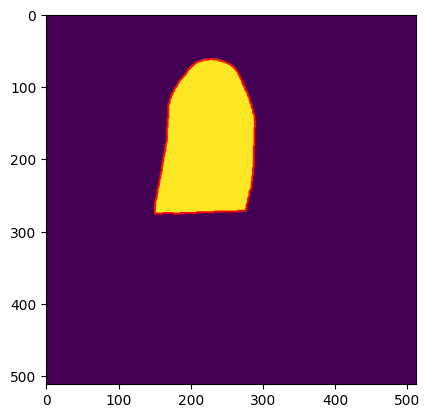

In [ ]:
appr_msk = approximate_polygon(contours, tolerance=0.5)

plt.imshow(new_mask)
plt.plot(appr_msk[:, 1], appr_msk[:, 0], alpha=0.9, c='red')

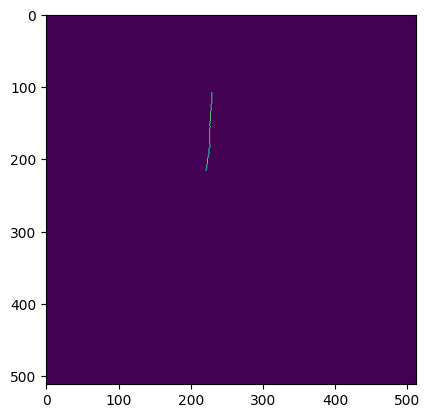

In [ ]:
from skimage.morphology import skeletonize


# perform skeletonization
skeleton = skeletonize(new_mask, method='lee')  # zhang

plt.imshow(skeleton)

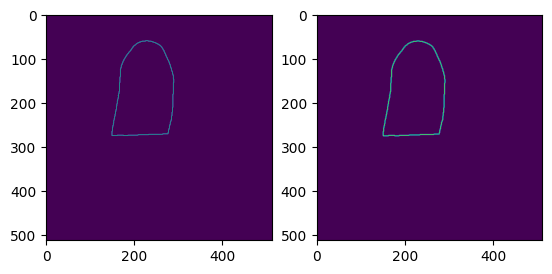

In [ ]:
from skimage import filters


edge_roberts = filters.roberts(new_mask)
edge_sobel = filters.sobel(new_mask)

plt.subplot(121)
plt.imshow(edge_roberts)

plt.subplot(122)
plt.imshow(edge_sobel)

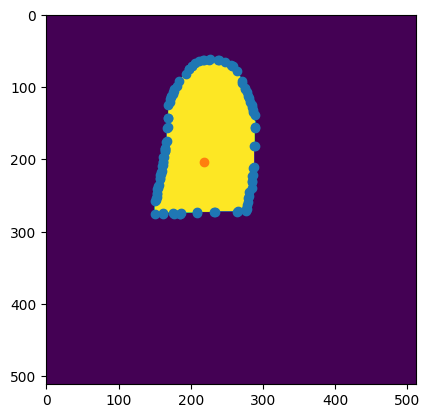

In [ ]:
plt.imshow(new_mask)
plt.scatter(appr_msk[:, 1], appr_msk[:, 0])
plt.scatter(cent_x, cent_y)

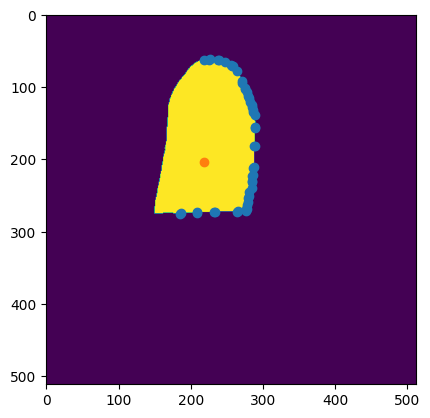

In [ ]:
plt.imshow(new_mask)
plt.scatter(appr_msk[-50:, 1], appr_msk[-50:, 0])
plt.scatter(cent_x, cent_y)

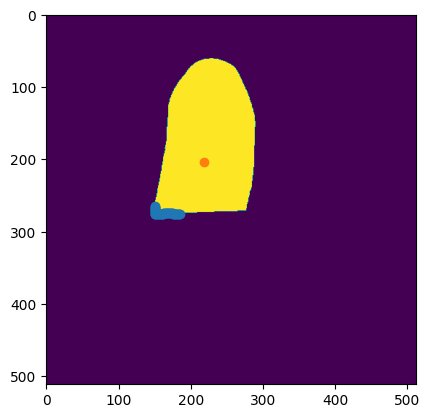

In [ ]:

plt.imshow(new_mask)
plt.scatter(contours[:50, 1], contours[:50, 0])
plt.scatter(cent_x, cent_y)

In [ ]:
points_x = [ (contours[i, 1]) for i in range(0, len(contours), 14) ]
points_y = [ (contours[i, 0]) for i in range(0, len(contours), 14) ]

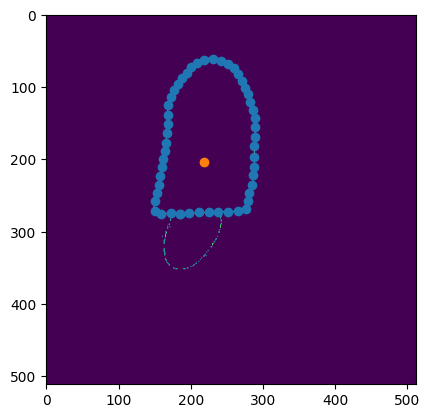

In [ ]:
plt.imshow(im_cont)
plt.scatter(points_x, points_y)
plt.scatter(cent_x, cent_y)

[[-1. -1. -1.]
 [-1.  8. -1.]
 [-1. -1. -1.]]


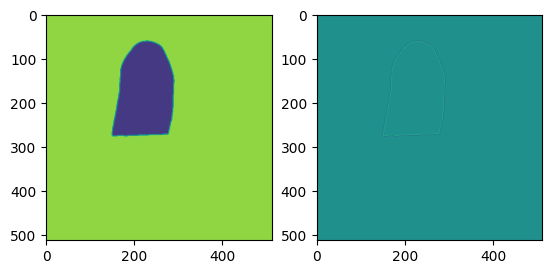

In [ ]:
# 1st way 
kernel = np.array([[-1, -1, -1],
                   [-1, 4, -1],
                   [-1, -1, -1]])

dst = cv2.filter2D(new_mask, -1, kernel)

plt.subplot(121)
plt.imshow(dst)

# 2nd way
kernel = np.ones((3,3),np.float32) * (-1)
kernel[1, 1] = 8
print(kernel)
dst = cv2.filter2D(new_mask, -1, kernel)

plt.subplot(122)
plt.imshow(dst)

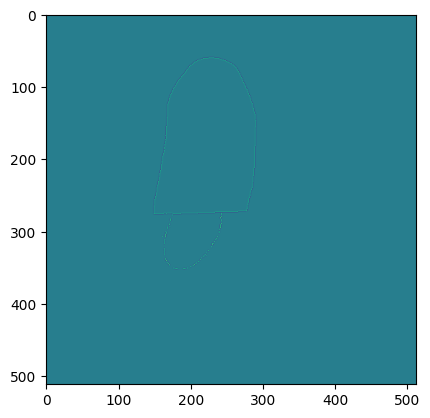

In [ ]:
# 1st way 
kernel = np.array([[0, -1, 0],
                   [-1, 4, -1],
                   [0, -1, 0]])

dst = cv2.filter2D(mask, -1, kernel)
plt.imshow(dst)

In [ ]:
np.squeeze(new_mask).shape

(512, 512)

In [ ]:
y, x = np.where(np.squeeze(new_mask) != 0)

In [ ]:
def cart2pol(x, y, cent_x, cent_y, norm=2):
    '''
    return phi, rho
    '''
    rho = (abs(x - cent_x) ** norm + abs(y - cent_y) ** norm) ** (1/norm)
    phi = np.arctan2(y - cent_y,  x - cent_x)
    return phi, rho

def pol2cart(phi, rho, cent_x, cent_y):
    '''
    return x, y
    '''
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return x + cent_x, y + cent_y

def variance_contour(cont_x, cont_y, vec_x, vec_y):
    var = []
    for x, y in zip(cont_x, cont_y):
        var.append(np.linalg.norm((x - vec_x * (x * vec_x + y * vec_y) / (vec_x**2 + vec_y**2), 
                                   y - vec_y * (x * vec_x + y * vec_y) / (vec_x**2 + vec_y**2))))
        
    return np.mean(var)

def mean_vector(cont_x, cont_y, x_point, y_point):
    vec_x, vec_y = [], []
    for x, y in zip(cont_x - x_point, cont_y - y_point):
        cur_dist = np.linalg.norm((x, y))
        if cur_dist != 0:
            vec_x.append(x / cur_dist)
            vec_y.append(y / cur_dist)
    return np.mean(vec_x), np.mean(vec_y)

In [ ]:
def get_contour_points(im, base_points=None, top_point=None, space='cart', kind='whole', center=None, num=None):
    '''
    center = [None, 'base', tuple]
    kind = ['whole', 'contour']
    form = ['polar', 'cart']
    '''
    im_cont = im.copy()
    im_cont = area2cont(im_cont)

    h = 1000
    w = 1000
    k_w = w / im_cont.shape[1]
    k_h = h / im_cont.shape[0]
    cont_y, cont_x = np.where(im_cont != 0)
    
    if not (base_points and top_point):
        top_point, base_l_point, base_r_point, orig_cent_x, orig_cent_y = get_main_points(im_cont, space='cart')
    else:
        base_l_point, base_r_point = base_points[0], base_points[1]
        orig_cent_x, orig_cent_y = np.mean(cont_x), np.mean(cont_y)
    
    cont_x, cont_y = cont_x * k_w, cont_y * k_h
    cent_x, cent_y = np.mean(cont_x), np.mean(cont_y)
    
    cont_phi, cont_rho = cart2pol(cont_x, cont_y, cent_x, cent_y)
    base_l_point = cart2pol(base_l_point[0]* k_w, base_l_point[1]* k_h, cent_x, cent_y)
    base_r_point = cart2pol(base_r_point[0]* k_w, base_r_point[1]* k_h, cent_x, cent_y)
    top_point = cart2pol(top_point[0]* k_w, top_point[1]* k_h, cent_x, cent_y)

    if kind == 'contour':
        cont_rho = cont_rho[(cont_phi <= min(base_l_point[0], base_r_point[0])) | (cont_phi >= max(base_l_point[0], base_r_point[0]))]
        cont_phi = cont_phi[(cont_phi <= min(base_l_point[0], base_r_point[0])) | (cont_phi >= max(base_l_point[0], base_r_point[0]))]
    
    if type(center) == tuple:
        cont_x, cont_y = pol2cart(cont_phi, cont_rho, cent_x, cent_y)
        cent_x, cent_y = center[0], center[1]
        cont_phi, cont_rho = cart2pol(cont_x, cont_y, cent_x, cent_y)
    elif type(center) == str:
        if center == 'base':
            cont_x, cont_y = pol2cart(cont_phi, cont_rho, cent_x, cent_y)
            top_point = pol2cart(top_point[0], top_point[1], cent_x, cent_y)
            base_l_point = pol2cart(base_l_point[0], base_l_point[1], cent_x, cent_y)
            base_r_point = pol2cart(base_r_point[0], base_r_point[1], cent_x, cent_y)
            cent_x, cent_y = (base_l_point[0] + base_r_point[0]) / 2, (base_l_point[1] + base_r_point[1]) / 2
            cont_phi, cont_rho = cart2pol(cont_x, cont_y, cent_x, cent_y)
            base_l_point = cart2pol(base_l_point[0], base_l_point[1], cent_x, cent_y)
            base_r_point = cart2pol(base_r_point[0], base_r_point[1], cent_x, cent_y)
            top_point = cart2pol(top_point[0], top_point[1], cent_x, cent_y)
            
    cont_phi[cont_phi >= max(base_l_point[0], base_r_point[0])] -= 2*np.pi
    indexes = np.argsort(cont_phi)
    cont_phi = cont_phi[indexes]
    cont_rho = cont_rho[indexes]
    
    if num:
        if num % 2:
            cont_phi_l =  cont_phi[cont_phi <= top_point[0]]
            cont_rho_l =  cont_rho[cont_phi <= top_point[0]]
            cont_phi_r =  cont_phi[cont_phi >= top_point[0]]
            cont_rho_r =  cont_rho[cont_phi >= top_point[0]]
            cont_phi = np.concatenate((
                np.array([base_l_point[0]]),
                cont_phi_l[np.linspace(0, len(cont_phi_l)-1, num // 2 + 1, dtype=int)][1:-1],
                np.array([top_point[0]]),
                cont_phi_r[np.linspace(0, len(cont_phi_r)-1, num // 2 + 1, dtype=int)][1:-1],
                np.array([base_r_point[0]]),
            ))
            cont_rho = np.concatenate((
                np.array([base_l_point[1]]),
                cont_rho_l[np.linspace(0, len(cont_rho_l)-1, num // 2 + 1, dtype=int)][1:-1],
                np.array([top_point[1]]),
                cont_rho_r[np.linspace(0, len(cont_rho_r)-1, num // 2 + 1, dtype=int)][1:-1],
                np.array([base_r_point[1]]),
            ))
        else:
            cont_phi = cont_phi[np.linspace(0, len(cont_phi)-1, num, dtype=int)]
            cont_rho = cont_rho[np.linspace(0, len(cont_rho)-1, num, dtype=int)]
        
    cont_x, cont_y = pol2cart(cont_phi, cont_rho, cent_x, cent_y)
    cont_x, cont_y = cont_x / k_w, cont_y / k_h
    cont_phi, cont_rho = cart2pol(cont_x, cont_y, orig_cent_x, orig_cent_y)
        
    if space == 'cart':
        cont_x, cont_y = pol2cart(cont_phi, cont_rho, orig_cent_x, orig_cent_y)
        return np.uint16(cont_x), np.uint16(cont_y), orig_cent_x, orig_cent_y
    elif space == 'polar':
        return cont_phi, cont_rho, orig_cent_x, orig_cent_y
    else:
        return

In [ ]:
def get_main_points(im, space='cart'):
    '''
    return apex_point, base_left_point, base_right_point
    '''
    im_cont = im.copy()
    im_cont = area2cont(im_cont)
    cont_y, cont_x = np.where(im_cont != 0)
    cent_x, cent_y = np.mean(cont_x), np.mean(cont_y)

    h = 1000
    w = 1000
    k_w = w / im_cont.shape[1]
    k_h = h / im_cont.shape[0]

    new_cont_x, new_cont_y = cont_x * k_w, cont_y * k_h
    cont_phi, cont_rho = cart2pol(new_cont_x, 
                                  new_cont_y, 
                                  np.mean(new_cont_x), 
                                  np.mean(new_cont_y))
    indexes = np.argsort(cont_phi)
    cont_phi = cont_phi[indexes]
    cont_rho = cont_rho[indexes]
    pos_indexes = cont_phi >= 0
    neg_indexes = cont_phi < 0
    index = np.argmax(cont_rho[neg_indexes])
    top_x, top_y = pol2cart(cont_phi[neg_indexes][index], 
                            cont_rho[neg_indexes][index], 
                            np.mean(new_cont_x), 
                            np.mean(new_cont_y))
    dict_base = {}
    for i in range(-100, 101):
        base_phi, base_rho = cart2pol(new_cont_x, 
                                      new_cont_y, 
                                      top_x+i, 
                                      top_y)
    #     plt.scatter(base_phi, base_rho)
        index = np.argmax(base_rho)
        if index in dict_base.keys():
            dict_base[index] += 1
        else:
            dict_base[index] = 1
    
    count = 0        
    for k in dict_base.keys():
        if count < dict_base[k]:
            index = k
            count = dict_base[k]    
    base_x, base_y = new_cont_x[index], new_cont_y[index]
    
    base_phi, base_rho = cart2pol(base_x, 
                                  base_y, 
                                  np.mean(new_cont_x), 
                                  np.mean(new_cont_y))
    
    check_r_phi = cont_phi[pos_indexes][cont_phi[pos_indexes] < base_phi]
    check_r_rho = cont_rho[pos_indexes][cont_phi[pos_indexes] < base_phi]
    check_l_phi = cont_phi[pos_indexes][cont_phi[pos_indexes] > base_phi]
    check_l_rho = cont_rho[pos_indexes][cont_phi[pos_indexes] > base_phi]
    
    r_x, r_y = pol2cart(check_r_phi, 
                        check_r_rho, 
                        np.mean(new_cont_x), 
                        np.mean(new_cont_y))

    l_x, l_y = pol2cart(check_l_phi, 
                        check_l_rho, 
                        np.mean(new_cont_x), 
                        np.mean(new_cont_y))

    var_l = variance_contour(l_x - base_x, l_y - base_y, l_x[0] - l_x[-1], l_y[0] - l_y[-1])
    var_r = variance_contour(r_x - base_x, r_y - base_y, r_x[0] - r_x[-1], r_y[0] - r_y[-1])
    length = 10
    var_near_l = variance_contour(l_x[:length] - base_x, l_y[:length] - base_y, l_x[0] - l_x[length-1], l_y[0] - l_y[length-1])
    var_near_r = variance_contour(r_x[-length:] - base_x, r_y[-length:] - base_y, r_x[-1] - r_x[-length], r_y[-1] - r_y[-length])
    base_l_x, base_l_y, base_r_x, base_r_y = None, None, None, None

    if var_r > var_l:
        check_phi = check_r_phi
        check_rho = check_r_rho
        check_x, check_y = r_x, r_y
        indexes = np.array([i for i, (x, y) in enumerate(zip(check_x, check_y)) if np.linalg.norm((x - base_x, y - base_y)) < 200], dtype=int)
        norm_vec_x, norm_vec_y = mean_vector(np.array(check_x)[indexes], np.array(check_y)[indexes], base_x, base_y)
        norm_vec_x, norm_vec_y = norm_vec_y, -norm_vec_x
        base_l_x, base_l_y = base_x / k_w, base_y / k_h
        edge_x, edge_y = check_x[0], check_y[0]
    else:
        check_phi = check_l_phi
        check_rho = check_l_rho
        check_x, check_y = l_x, l_y
        indexes = np.array([i for i, (x, y) in enumerate(zip(check_x, check_y)) if np.linalg.norm((x - base_x, y - base_y)) < 200], dtype=int)
        norm_vec_x, norm_vec_y = mean_vector(np.array(check_x)[indexes], np.array(check_y)[indexes], base_x, base_y)
        norm_vec_x, norm_vec_y = -norm_vec_y, norm_vec_x
        base_r_x, base_r_y = base_x / k_w, base_y / k_h
        edge_x, edge_y = check_x[-1], check_y[-1]
    
    k = 10
    c_x, c_y = base_x + k * norm_vec_x, base_y + k * norm_vec_y
    while np.linalg.norm((c_x - base_x, c_y - base_y)) <= np.linalg.norm((edge_x - c_x, edge_y - c_y)) or c_y > top_y:
        if k > 1000:
            break
        k += 1
        c_x, c_y = base_x + k * norm_vec_x, base_y + k * norm_vec_y
    
    check_phi, check_rho = cart2pol(check_x, 
                                    check_y,
                                    c_x,
                                    c_y,
                                   )
   
    check_phi[check_phi <= -np.pi/2] += 2*np.pi
    
    index = np.argmax(check_rho)
    base_x, base_y = check_x[index], check_y[index]

    if base_r_x is None and base_r_y is None:
        base_r_x, base_r_y = base_x / k_w, base_y / k_h

    elif base_l_x is None and base_l_y is None:
        base_l_x, base_l_y = base_x / k_w, base_y / k_h
    
    cont_phi, cont_rho = cart2pol(cont_x, cont_y, (base_l_x + base_r_x) / 2, (base_l_y + base_r_y) / 2)
    index = np.argmax(cont_rho)
    apex_phi, apex_rho = cont_phi[index], cont_rho[index]
    apex_x, apex_y = pol2cart(apex_phi, 
                              apex_rho, 
                              (base_l_x + base_r_x) / 2, 
                              (base_l_y + base_r_y) / 2)
        
    
    if space == 'polar':
        apex_phi, apex_rho = cart2pol(apex_x, 
                                      apex_y, 
                                      cent_x, 
                                      cent_y)
        base_r_phi, base_r_rho = cart2pol(base_r_x, 
                                          base_r_y, 
                                          cent_x, 
                                          cent_y)
        base_l_phi, base_l_rho = cart2pol(base_l_x, 
                                          base_l_y, 
                                          cent_x, 
                                          cent_y)
        return (apex_phi, apex_rho), (base_l_phi, base_l_rho), (base_r_phi, base_r_rho), cent_x, cent_y
    elif space == 'cart':
        return (apex_x, apex_y), (base_l_x, base_l_y), (base_r_x, base_r_y), cent_x, cent_y
    else:
        return

In [ ]:
apex_point, base_l_point, base_r_point, cent_x, cent_y = get_main_points(edges2, space='cart')

base_points = [base_l_point, base_r_point]

base_points

[(152.0, 275.0), (276.0, 270.0)]

In [ ]:
kind='contour'
center=None
num=30

cont_x, cont_y, *_ = get_contour_points(edges2, base_points=base_points, top_point=apex_point, kind=kind, center=center, num=num)

cont_x

array([152, 150, 152, 157, 160, 163, 166, 167, 168, 170, 175, 182, 191,
       199, 211, 229, 246, 259, 267, 275, 281, 286, 289, 289, 288, 287,
       287, 284, 280, 276], dtype=uint16)

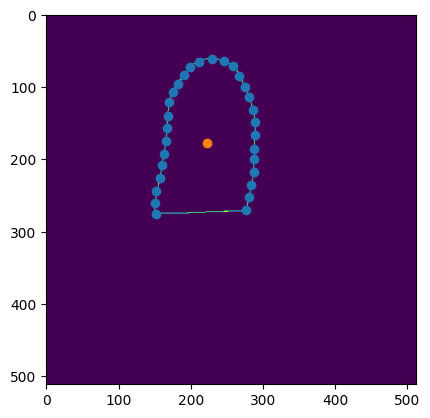

In [ ]:
plt.imshow(edges2)
plt.scatter(cont_x, cont_y)
plt.scatter(cent_x, cent_y)

In [ ]:
from Utils import get_image_filepaths, get_data, dice_coef
from Unet import UNet, build_unet

In [ ]:
edges2

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
img_path = r'/home/suetin/Projects/VSCode/ComputerVision/HeartSegmentation/train/images/images/2010.jpeg'
image = cv2.imread(img_path, 0)
image = image / image.max()

In [ ]:
IMAGE_SIZE = (512, 512)

# Init model
model = build_unet(input_shape=(IMAGE_SIZE + (1,))) # UNet((IMAGE_SIZE + (1,)), filters, is_dropout=False)
# Load model' weights
weights_path = r'/home/suetin/Projects/VSCode/ComputerVision/HeartSegmentation/TensorFlow/dev/Weights/UNet-v1.h5'  # r'U512_bs3_pretrain.h5'
model.load_weights(weights_path)

2023-07-14 19:40:20.438724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-14 19:40:20.478684: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-14 19:40:20.478807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## First way

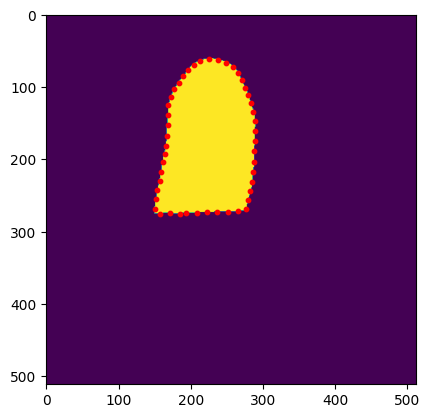

In [ ]:
from skimage import measure


# Find contours at a constant value of 0.8
contours = measure.find_contours(new_mask, 0.8)[0]   # First index because it's list
# Find coordinates of points 
points_x = [ (contours[i, 1]) for i in range(0, len(contours), 15) ]
points_y = [ (contours[i, 0]) for i in range(0, len(contours), 15) ]

plt.imshow(new_mask)
plt.scatter(points_x, points_y, s=10, c='red')


2023-07-14 19:40:22.905341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902


1/1 [==============================] - 4s 4s/step


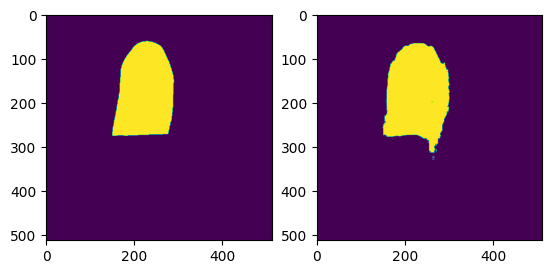

In [ ]:
pred = model.predict(np.expand_dims(image, axis=[0, 3]))

plt.subplot(121)
plt.imshow(new_mask)

plt.subplot(122)
plt.imshow(pred[0])

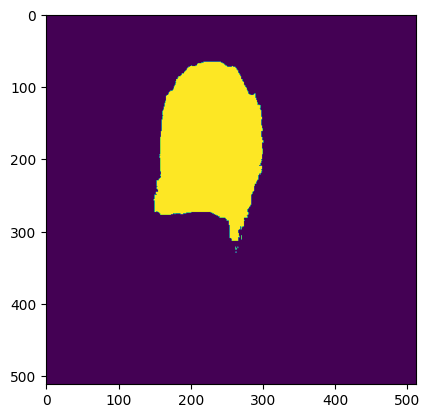

In [ ]:
pred = np.where(pred[0, :, :, 0] > 0.5, 1, 0)
plt.imshow(pred)

In [ ]:
pred.shape

(512, 512)

CPU times: user 27.3 ms, sys: 18.9 ms, total: 46.1 ms
Wall time: 18.6 ms


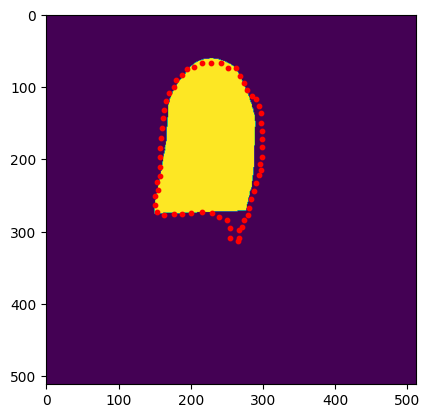

In [ ]:
%%time
# Find contours at a constant value of 0.8
contours = measure.find_contours(pred, 0.8)[0]   # First index because it's list
# Find coordinates of points 
points_x = [ (contours[i, 1]) for i in range(0, len(contours), 15) ]
points_y = [ (contours[i, 0]) for i in range(0, len(contours), 15) ]

plt.imshow(new_mask)
plt.scatter(points_x, points_y, s=10, c='red')

In [17]:
from Utils.ImageGenerator import ImageSegmentationGenerator

In [18]:
# Init params
main_path = '/home/suetin/Projects/VSCode/ComputerVision/HeartSegmentation' # r'.../../Data'
print(os.listdir(main_path))
train_path = os.path.join(main_path, 'train')
test_path = os.path.join(main_path, 'test')

# 
test_gena = ImageSegmentationGenerator(
    paths=[
        os.path.join(test_path, 'images'),
        os.path.join(test_path, 'masks'),
    ],
    out_shape=(512, 512),
    batch_size=3,
    features=[255], # features=[127, 255],
)

['TensorFlow', 'train', 'test', 'valid']


2023-07-19 20:22:32.832454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-19 20:22:32.872999: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-19 20:22:32.873125: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [19]:
x, y = test_gena[111]

x.shape, y.shape

(TensorShape([3, 512, 512, 1]), TensorShape([3, 512, 512, 1]))

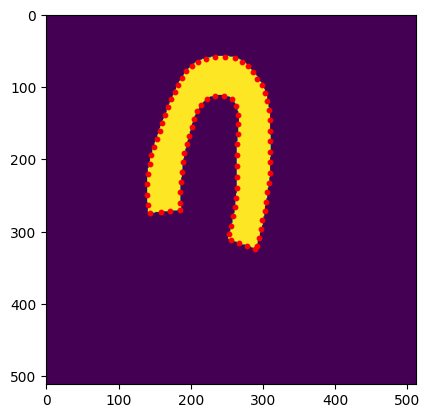

In [21]:
y_mask = y[0, :, :, 0].numpy()

# Find contours at a constant value of 0.8
contours = measure.find_contours(y_mask, 0.8)[0]   # First index because it's list
# Find coordinates of points 
points_x = [ (contours[i, 1]) for i in range(0, len(contours), 15) ]
points_y = [ (contours[i, 0]) for i in range(0, len(contours), 15) ]

plt.imshow(y_mask)
plt.scatter(points_x, points_y, s=10, c='red')